In [1]:
!git clone https://github.com/chrisyu-uiuc/revisit-deepcoxmixtures-cs598-uiuc
#ref : https://github.com/autonlab/auton-survival/blob/master/examples/CV%20Survival%20Regression%20on%20SUPPORT%20Dataset.ipynb

Cloning into 'revisit-deepcoxmixtures-cs598-uiuc'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 134 (delta 53), reused 123 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 7.99 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
!cd revisit-deepcoxmixtures-cs598-uiuc && pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 87.5 MB/s eta 0:00:00
   ━━

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/breast-cancer-dataset-used-royston-and-altman")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/breast-cancer-dataset-used-royston-and-altman


In [6]:
import shutil
import os

# Correct source path (no /1/ needed)
source_path = "/kaggle/input/breast-cancer-dataset-used-royston-and-altman/gbsg.csv"
destination_dir = "/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/datasets"

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the file
shutil.copy(source_path, destination_dir)

print(f"File successfully copied from {source_path} to {destination_dir}")

File successfully copied from /kaggle/input/breast-cancer-dataset-used-royston-and-altman/gbsg.csv to /content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/datasets


In [7]:
import numpy as np
import sys
sys.path.append('/content/revisit-deepcoxmixtures-cs598-uiuc')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from auton_survival.preprocessing import Preprocessor
import numpy as np

# Load dataset
def load_data(filepath):
    data = pd.read_csv(filepath)
    data = data.rename(columns={
        'status': 'event',
        'rfstime': 'time'
    })
    # Convert 'event' to binary: 1 for event occurred, 0 for censored
    data['event'] = data['event'].apply(lambda x: 1 if x == 1 else 0)
    return data

filepath = '/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/datasets/gbsg.csv'  # Replace with your actual file path
data = load_data(filepath)

# Define categorical and numerical features based on the new dataset
cat_feats = ['meno', 'grade', 'hormon']  # Categorical features
num_feats = ['age', 'size', 'nodes', 'pgr', 'er']  # Numerical features

features = data[cat_feats + num_feats]
outcomes = data[['event', 'time']]

# Split into training (60%), validation (20%), and test (20%)
x_tr, x_te, y_tr, y_te = train_test_split(features, outcomes, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

# Fit the preprocessor
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean')
transformer = preprocessor.fit(features, cat_feats=cat_feats, num_feats=num_feats, one_hot=True, fill_value=-1)

# Transform the training, validation, and test datasets
x_tr = transformer.transform(x_tr)
x_val = transformer.transform(x_val)
x_te = transformer.transform(x_te)

# Calculate the quartiles of survival times
times = np.quantile(y_tr['time'], [0.25, 0.5, 0.75]).tolist()

# Output transformed datasets
print("Training features (x_tr):", x_tr.shape)
print("Validation features (x_val):", x_val.shape)
print("Test features (x_te):", x_te.shape)

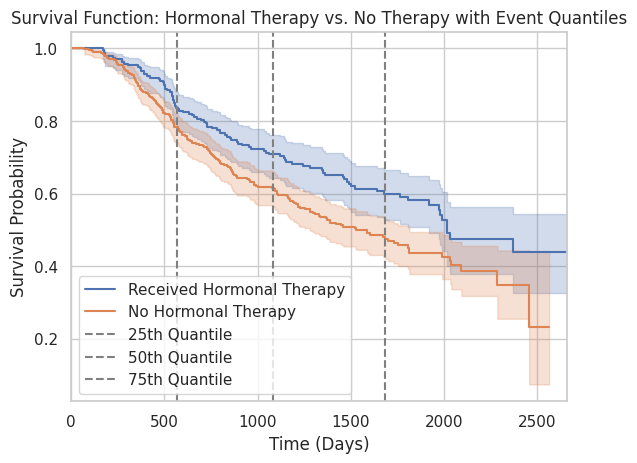

Log-rank test p-value: 0.0034272822647457863


In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Initialize the Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Plot survival function for patients who received hormonal therapy (hormon = 1)
group_hormon = data[data['hormon'] == 1]
kmf.fit(durations=group_hormon['time'], event_observed=group_hormon['event'], label='Received Hormonal Therapy')
kmf.plot_survival_function()

# Plot survival function for patients who did not receive hormonal therapy (hormon = 0)
group_no_hormon = data[data['hormon'] == 0]
kmf.fit(durations=group_no_hormon['time'], event_observed=group_no_hormon['event'], label='No Hormonal Therapy')
kmf.plot_survival_function()

# Add quantiles as vertical dashed lines
quantiles = [0.25, 0.50, 0.75]
for q in quantiles:
    plt.axvline(x=data['time'].quantile(q), color='grey', linestyle='--', label=f'{int(q*100)}th Quantile')

# Set x-axis limit (adjust based on your time units)
plt.xlim(0, data['time'].max())

# Add title, labels, and legend
plt.title('Survival Function: Hormonal Therapy vs. No Therapy with Event Quantiles')
plt.xlabel('Time (Days)')  # Assuming rfstime is in days based on your sample data
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

from lifelines.statistics import logrank_test

# Perform log-rank test to compare survival curves
results = logrank_test(
    durations_A=group_hormon['time'], durations_B=group_no_hormon['time'],
    event_observed_A=group_hormon['event'], event_observed_B=group_no_hormon['event']
)

# Print the p-value
print(f"Log-rank test p-value: {results.p_value}")


In [ ]:
# Create a mask for patients who received hormonal therapy
hormon_mask = features['hormon'] == 1  # 1 = received hormonal therapy

# Filter the dataset for patients who received hormonal therapy
features_hormon = features[hormon_mask]
outcomes_hormon = outcomes[hormon_mask]

# Split the hormon therapy dataset into training, validation, and test data
x_tr_hormon, x_te_hormon, y_tr_hormon, y_te_hormon = train_test_split(
    features_hormon, outcomes_hormon, test_size=0.2, random_state=1
)
x_tr_hormon, x_val_hormon, y_tr_hormon, y_val_hormon = train_test_split(
    x_tr_hormon, y_tr_hormon, test_size=0.25, random_state=1
)  # 0.25 * 0.8 = 0.2

# Fit the preprocessor to the hormon therapy data and transform the splits
hormon_transformer = preprocessor.fit(
    features_hormon,
    cat_feats=cat_feats,
    num_feats=num_feats,
    one_hot=True,
    fill_value=-1
)

x_tr_hormon = hormon_transformer.transform(x_tr_hormon)
x_val_hormon = hormon_transformer.transform(x_val_hormon)
x_te_hormon = hormon_transformer.transform(x_te_hormon)

# Output transformed datasets
print("Training features (Hormon Therapy):", x_tr_hormon.shape)
print("Validation features (Hormon Therapy):", x_val_hormon.shape)
print("Test features (Hormon Therapy):", x_te_hormon.shape)

# Repeat the same process for patients without hormonal therapy
no_hormon_mask = features['hormon'] == 0
features_no_hormon = features[no_hormon_mask]
outcomes_no_hormon = outcomes[no_hormon_mask]

x_tr_no_hormon, x_te_no_hormon, y_tr_no_hormon, y_te_no_hormon = train_test_split(
    features_no_hormon, outcomes_no_hormon, test_size=0.2, random_state=1
)
x_tr_no_hormon, x_val_no_hormon, y_tr_no_hormon, y_val_no_hormon = train_test_split(
    x_tr_no_hormon, y_tr_no_hormon, test_size=0.25, random_state=1
)

no_hormon_transformer = preprocessor.fit(
    features_no_hormon,
    cat_feats=cat_feats,
    num_feats=num_feats,
    one_hot=True,
    fill_value=-1
)

x_tr_no_hormon = no_hormon_transformer.transform(x_tr_no_hormon)
x_val_no_hormon = no_hormon_transformer.transform(x_val_no_hormon)
x_te_no_hormon = no_hormon_transformer.transform(x_te_no_hormon)

print("\nTraining features (No Hormon Therapy):", x_tr_no_hormon.shape)
print("Validation features (No Hormon Therapy):", x_val_no_hormon.shape)
print("Test features (No Hormon Therapy):", x_te_no_hormon.shape)

Training features (Hormon Therapy): (147, 8)
Validation features (Hormon Therapy): (49, 8)
Test features (Hormon Therapy): (50, 8)

Training features (No Hormon Therapy): (264, 8)
Validation features (No Hormon Therapy): (88, 8)
Test features (No Hormon Therapy): (88, 8)


In [ ]:
import numpy as np
from auton_survival.experiments import SurvivalRegressionCV

# Parameter grid for Cox PH model
param_grid = {'l2': [1e-3, 1e-2, 1e-1]}

# Fit Cox PH model for all patients
cph_experiment = SurvivalRegressionCV(model='cph', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
cph_model = cph_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

times_hormon = np.quantile(y_tr_hormon['time'], [0.25, 0.5, 0.75]).tolist()
cph_hormon_experiment = SurvivalRegressionCV(model='cph', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
cph_hormon_model = cph_hormon_experiment.fit(x_tr_hormon.astype(np.float64), y_tr_hormon.astype(np.float64), times_hormon, metric='brs')

At hyper-param {'l2': 0.001}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.01}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.1}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.001}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.01}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.1}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4


In [ ]:
param_grid = {
    'k': [3, 4, 6],  # Number of mixture components K
    'layers': [[50, 100]],  # Units in each hidden layer
    'batch_size': [128],  # Mini-batch size (fixed)
    'lr': [1e-3],  # Learning rate (fixed)
}

dcm_experiment = SurvivalRegressionCV(model='dcm', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
dcm_model = dcm_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

dcm_non_male_experiment = SurvivalRegressionCV(model='dcm', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
dcm_non_white_model = dcm_non_male_experiment.fit(x_tr_hormon.astype(np.float64), y_tr_hormon.astype(np.float64), times_hormon, metric='brs')


At hyper-param {'batch_size': 128, 'k': 3, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


 52%|█████▏    | 26/50 [00:01<00:01, 22.58it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 82%|████████▏ | 41/50 [00:01<00:00, 29.02it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:01<00:00, 40.28it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


 94%|█████████▍| 47/50 [00:01<00:00, 37.71it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 78%|███████▊  | 39/50 [00:01<00:00, 38.72it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'k': 4, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:01<00:00, 35.71it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 32%|███▏      | 16/50 [00:00<00:00, 34.07it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 66%|██████▌   | 33/50 [00:00<00:00, 34.02it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:01<00:00, 34.77it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 82%|████████▏ | 41/50 [00:01<00:00, 32.32it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'k': 6, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


 80%|████████  | 40/50 [00:01<00:00, 20.27it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 62%|██████▏   | 31/50 [00:01<00:00, 23.56it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 50%|█████     | 25/50 [00:00<00:00, 27.71it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


 48%|████▊     | 24/50 [00:00<00:00, 28.03it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 68%|██████▊   | 34/50 [00:01<00:00, 28.88it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
 30%|███       | 15/50 [00:00<00:01, 21.62it/s]


At hyper-param {'batch_size': 128, 'k': 3, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


 20%|██        | 10/50 [00:00<00:00, 71.34it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 86%|████████▌ | 43/50 [00:00<00:00, 86.75it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 96%|█████████▌| 48/50 [00:00<00:00, 76.77it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 79.45it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 18%|█▊        | 9/50 [00:00<00:00, 65.77it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'k': 4, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


  6%|▌         | 3/50 [00:00<00:01, 37.58it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 16%|█▌        | 8/50 [00:00<00:00, 54.77it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 70.09it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


 60%|██████    | 30/50 [00:00<00:00, 70.66it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 24%|██▍       | 12/50 [00:00<00:00, 63.92it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'k': 6, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


 12%|█▏        | 6/50 [00:00<00:00, 52.82it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 48%|████▊     | 24/50 [00:00<00:00, 56.56it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 34%|███▍      | 17/50 [00:00<00:00, 53.89it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


 30%|███       | 15/50 [00:00<00:00, 54.97it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 38%|███▊      | 19/50 [00:00<00:00, 52.91it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
100%|██████████| 50/50 [00:01<00:00, 38.87it/s]


In [ ]:
param_grid = {'k' : [3, 4],
              'distribution' : ['Weibull'],
              'lr' : [1e-4, 1e-3],
              'batch_size': [128,256],  # Mini-batch size (fixed)
              'layers' : [[50,100]]}

dsm_experiment = SurvivalRegressionCV(model='dsm', num_folds=5, hyperparam_grid=param_grid, random_seed=0)
dsm_model = dsm_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

dsm_non_white_experiment = SurvivalRegressionCV(model='dsm', num_folds=5, hyperparam_grid=param_grid, random_seed=0)
dsm_non_white_model = dsm_non_white_experiment.fit(x_tr_hormon.astype(np.float64), y_tr_hormon.astype(np.float64), times_hormon, metric='brs')


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


 76%|███████▌  | 38/50 [00:00<00:00, 50.45it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 52.85it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 28%|██▊       | 14/50 [00:00<00:01, 34.37it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 71.99it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 71.91it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


 76%|███████▌  | 38/50 [00:00<00:00, 53.22it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 72.99it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 28%|██▊       | 14/50 [00:00<00:01, 34.73it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 52.61it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 74.44it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


100%|██████████| 50/50 [00:01<00:00, 49.96it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 65.54it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:01<00:00, 41.14it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


 98%|█████████▊| 49/50 [00:01<00:00, 47.70it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:01<00:00, 33.88it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 67.44it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 58.27it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 65.55it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


 98%|█████████▊| 49/50 [00:01<00:00, 36.41it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 68.61it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


 60%|██████    | 30/50 [00:00<00:00, 44.40it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 48%|████▊     | 24/50 [00:00<00:00, 53.35it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 44%|████▍     | 22/50 [00:00<00:00, 51.53it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 95.73it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 87.04it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


 60%|██████    | 30/50 [00:00<00:00, 59.01it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 48%|████▊     | 24/50 [00:00<00:00, 51.49it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 44%|████▍     | 22/50 [00:00<00:00, 32.79it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 99.08it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 87.76it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 91.62it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 48%|████▊     | 24/50 [00:00<00:00, 52.74it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 44%|████▍     | 22/50 [00:00<00:00, 45.11it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 88.24it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 71.99it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 88.30it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


 48%|████▊     | 24/50 [00:00<00:00, 43.83it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


 44%|████▍     | 22/50 [00:00<00:00, 48.61it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 64.64it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 90.88it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
100%|██████████| 50/50 [00:00<00:00, 73.97it/s]


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 165.99it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 171.09it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 146.05it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 123.13it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 117.33it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 167.74it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 154.55it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 165.93it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 166.95it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 136.40it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 150.57it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 129.32it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 150.13it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 149.36it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 135.33it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 142.52it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 115.28it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 152.59it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 145.03it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 143.77it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 128.41it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 152.82it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 152.34it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 105.76it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 148.75it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 3, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 159.27it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 159.23it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 133.09it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 123.09it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 159.51it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.0001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 122.01it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 144.27it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 113.35it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 146.82it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 142.35it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 256, 'distribution': 'Weibull', 'k': 4, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:00<00:00, 104.39it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:00<00:00, 149.10it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:00<00:00, 139.11it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:00<00:00, 125.55it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:00<00:00, 120.52it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
100%|██████████| 50/50 [00:01<00:00, 48.28it/s]


In [ ]:
#/auton_survival/estimators.py #470
#def _predict_rsf(model, features, times):
#  if isinstance(times, (int, float)):
#    times = [float(times)]
#
#  survival_predictions = model.predict_survival_function(features.values, return_array=True)
#  event_times = model.event_times_ if hasattr(model, 'event_times_') else model.unique_times_
#
#  survival_predictions = pd.DataFrame(survival_predictions, columns=event_times).T
#
#  return __interpolate_missing_times(survival_predictions, times)


# Define parameters for tuning the model
param_grid = {'n_estimators' : [150, 200, 250],
              'max_depth' : [5],
              'max_features' : ['sqrt']
             }
rsf_experiment = SurvivalRegressionCV(model='rsf', num_folds=5, hyperparam_grid=param_grid, random_seed=8)
rsf_model = rsf_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

rsf_non_white_experiment = SurvivalRegressionCV(model='rsf', num_folds=5, hyperparam_grid=param_grid, random_seed=8)
rsf_non_white_model = rsf_non_white_experiment.fit(x_tr_hormon.astype(np.float64), y_tr_hormon.astype(np.float64), times_hormon, metric='brs')



At hyper-param {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 150}
At fold: 0


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
At fold: 0


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 250}
At fold: 0


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 150}
At fold: 0


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
At fold: 0


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 250}
At fold: 0


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


In [ ]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from auton_survival.metrics import survival_regression_metric

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec


def plot_performance_metrics(results, times):
  colors = ['blue', 'purple', 'orange', 'green', 'black']
  gs = gridspec.GridSpec(1, len(results), wspace=1)
  for fi, result in enumerate(results.keys()):
    val = results[result]
    x = [str(round(t, 1)) for t in times]
    ax = plt.subplot(gs[0, fi]) # row 0, col 0
    ax.set_xlabel('Time')
    ax.set_ylabel(result)
    ax.set_ylim(0, 1)
    ax.bar(x, val, color=colors[fi])
    plt.xticks(rotation=30)
  plt.show()

def print_performance_metrics(array):
    max_val = np.max(array)  # Use numpy functions for array operations
    min_val = np.min(array)
    difference = max_val - min_val
    median = np.median(array)  # Calculate the median using numpy
    print(array)
def plot_auc(auc_values, times):
    plt.figure(figsize=(8, 6))
    plt.plot(times, auc_values, marker='o', color='blue', label='AUC')
    plt.xlabel('Time')
    plt.ylabel('Area Under Curve')
    plt.title('Area Under Curve Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

#times = np.quantile(y_te.time, [0.25, 0.5, 0.75]).tolist()
#y_te_non_white_times = np.quantile(y_te_non_white.time, [0.25, 0.5, 0.75]).tolist()
#print(times)
#print(y_te_non_white_times)

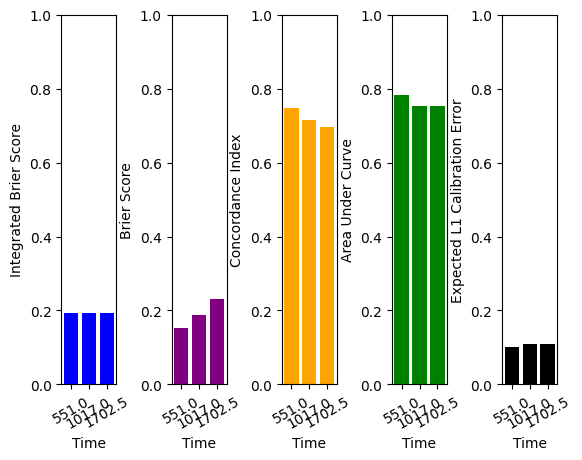

[0.78226394 0.75290344 0.75426965]
[np.float64(0.746877561393546), np.float64(0.715099167211746), np.float64(0.6971099672044107)]
[0.099959   0.10809837 0.10803247]


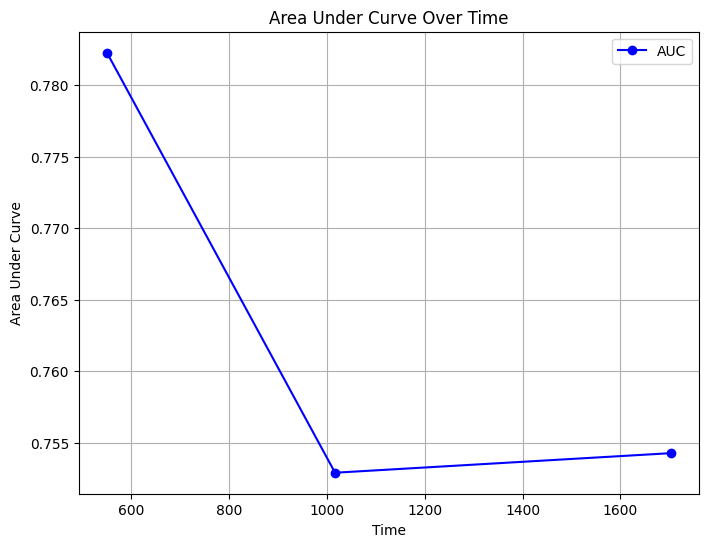

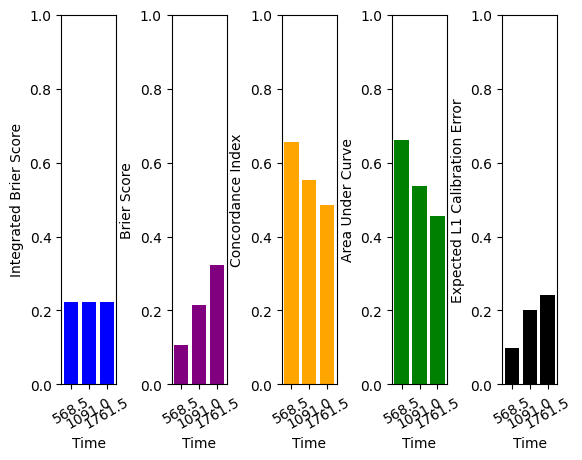

[0.66217903 0.5377406  0.45547603]
[np.float64(0.6557004072011601), np.float64(0.5541195524410802), np.float64(0.48626389263832276)]
[0.09819676 0.20006231 0.24242376]


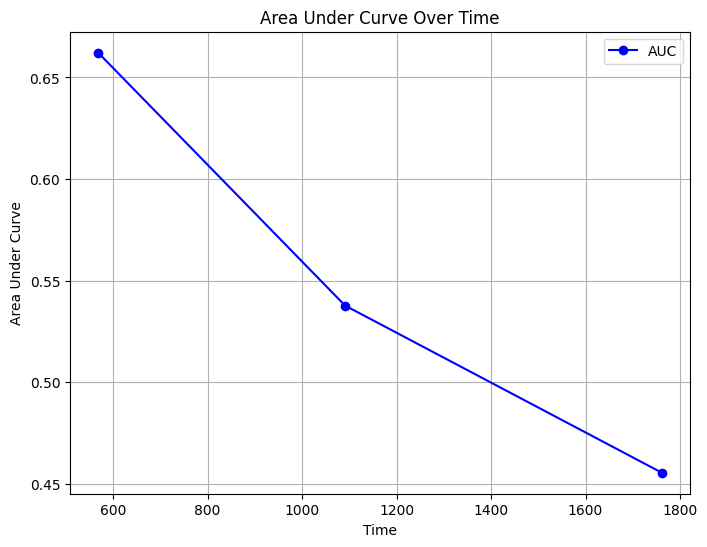

In [ ]:
cph_predictions_te = cph_model.predict_survival(x_te.astype(np.float64), times)
cph_results = dict()
cph_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Expected L1 Calibration Error'] = np.array(list(survival_regression_metric('ece', outcomes=y_te, predictions=cph_predictions_te, times=times, outcomes_train=y_tr).values()))

plot_performance_metrics(cph_results, times)
print_performance_metrics(cph_results['Area Under Curve'])
print_performance_metrics(cph_results['Concordance Index'])
print_performance_metrics(cph_results['Expected L1 Calibration Error'])
plot_auc(cph_results['Area Under Curve'], times)


cph_non_white_predictions_te = cph_hormon_model.predict_survival(x_te_hormon.astype(np.float64), times_hormon)
cph_non_white_results = dict()
cph_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_hormon, predictions=cph_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
cph_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_hormon, predictions=cph_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
cph_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_hormon, predictions=cph_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
cph_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_hormon, predictions=cph_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
cph_non_white_results['Expected L1 Calibration Error'] = np.array(list(survival_regression_metric('ece', outcomes=y_te_hormon, predictions=cph_non_white_predictions_te, times=times_hormon, outcomes_train=y_tr_hormon).values()))

plot_performance_metrics(cph_non_white_results, times_hormon)
print_performance_metrics(cph_non_white_results['Area Under Curve'])
print_performance_metrics(cph_non_white_results['Concordance Index'])
print_performance_metrics(cph_non_white_results['Expected L1 Calibration Error'])
plot_auc(cph_non_white_results['Area Under Curve'], times_hormon)

/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


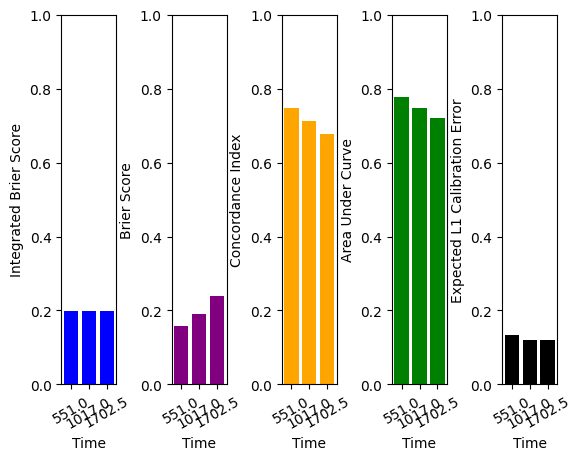

[0.77677236 0.74762533 0.72199985]
[np.float64(0.7484998797256525), np.float64(0.7125431818827916), np.float64(0.6784357509772129)]
[0.13362005 0.12029634 0.11968829]


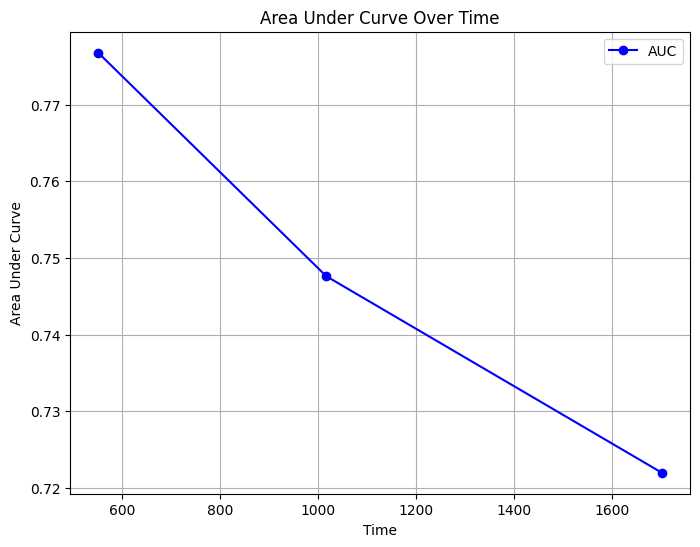

/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


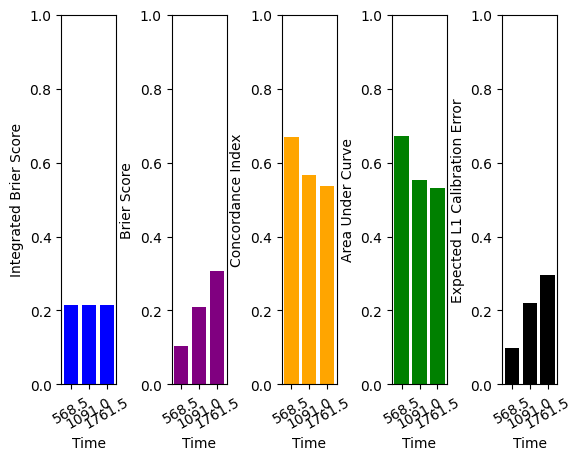

[0.67321751 0.55224902 0.53147027]
[np.float64(0.6691173358657243), np.float64(0.5659632977242653), np.float64(0.537769691506141)]
[0.09817455 0.21944751 0.29605809]


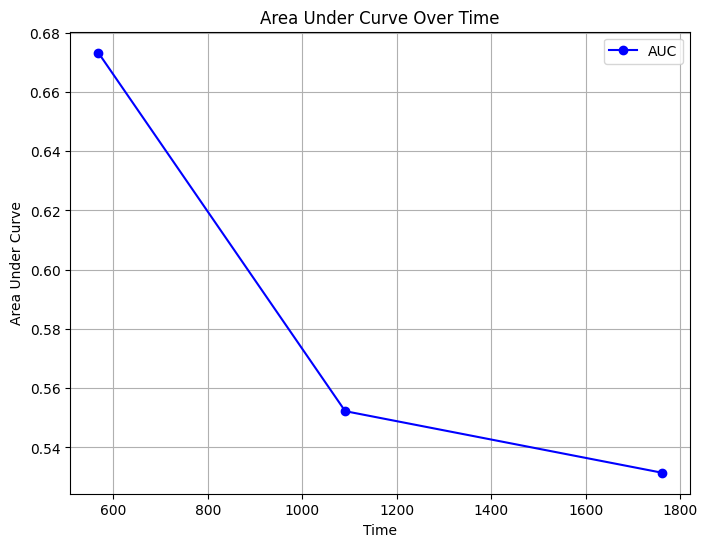

/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


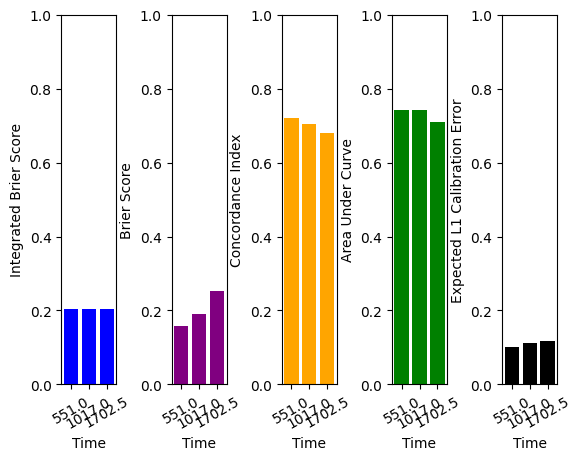

[0.74276987 0.74365478 0.710483  ]
[np.float64(0.7214207640256838), np.float64(0.7052797282270995), np.float64(0.6803297810869492)]
[0.10253736 0.11211401 0.11645027]


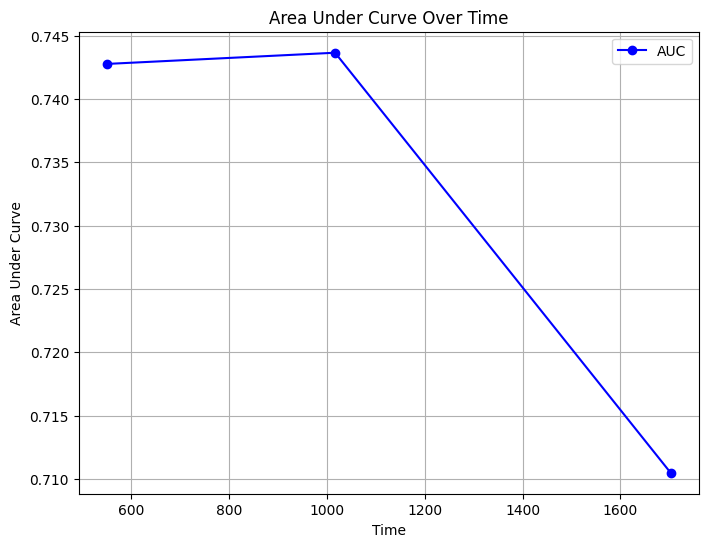

/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


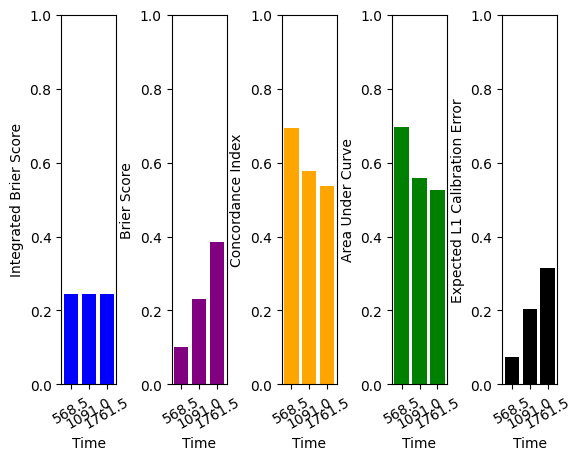

[0.69655586 0.55761525 0.52581213]
[np.float64(0.6948728620662061), np.float64(0.5761134820415613), np.float64(0.537517346795811)]
[0.0729304  0.20348251 0.31485012]


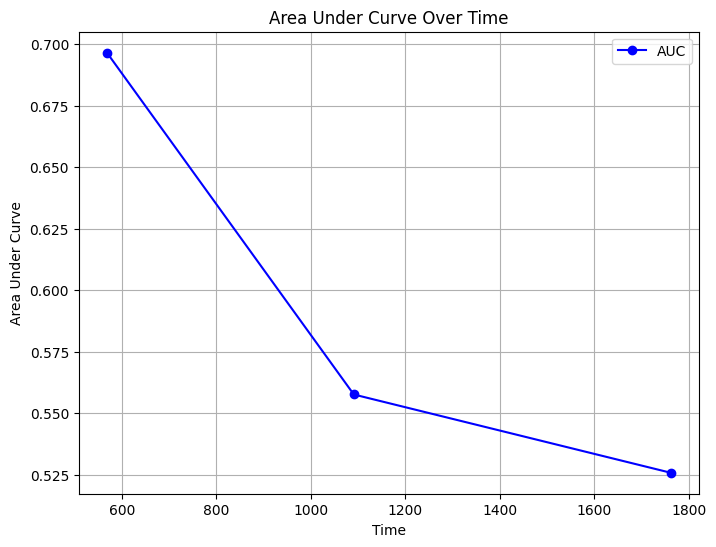

In [ ]:
dcm_predictions_te = dcm_model.predict_survival(x_te.astype(np.float64), times)
dcm_results = dict()
dcm_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Expected L1 Calibration Error'] = np.array(list(survival_regression_metric('ece', outcomes=y_te, predictions=dcm_predictions_te, times=times, outcomes_train=y_tr).values()))

plot_performance_metrics(dcm_results, times)
print_performance_metrics(dcm_results['Area Under Curve'])
print_performance_metrics(dcm_results['Concordance Index'])
print_performance_metrics(dcm_results['Expected L1 Calibration Error'])
plot_auc(dcm_results['Area Under Curve'], times)

dcm_non_white_predictions_te = dcm_non_white_model.predict_survival(x_te_hormon.astype(np.float64), times_hormon)
dcm_non_white_results = dict()
dcm_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dcm_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dcm_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dcm_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dcm_non_white_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon) .values() ))

plot_performance_metrics(dcm_non_white_results, times_hormon)
print_performance_metrics(dcm_non_white_results['Area Under Curve'])
print_performance_metrics(dcm_non_white_results['Concordance Index'])
print_performance_metrics(dcm_non_white_results['Expected L1 Calibration Error'])
plot_auc(dcm_non_white_results['Area Under Curve'], times_hormon)


dsm_predictions_te = dsm_model.predict_survival(x_te.astype(np.float64), times)
dsm_results = dict()
dsm_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr).values() ))

plot_performance_metrics(dsm_results, times)
print_performance_metrics(dsm_results['Area Under Curve'])
print_performance_metrics(dsm_results['Concordance Index'])
print_performance_metrics(dsm_results['Expected L1 Calibration Error'])
plot_auc(dsm_results['Area Under Curve'], times)

dsm_non_white_predictions_te = dsm_non_white_model.predict_survival(x_te_hormon.astype(np.float64), times_hormon)
dsm_non_white_results = dict()
dsm_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_hormon, predictions=dsm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dsm_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_hormon, predictions=dsm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dsm_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_hormon, predictions=dsm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dsm_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_hormon, predictions=dsm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
dsm_non_white_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te_hormon, predictions=dsm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon) .values() ))

plot_performance_metrics(dsm_non_white_results, times_hormon)
print_performance_metrics(dsm_non_white_results['Area Under Curve'])
print_performance_metrics(dsm_non_white_results['Concordance Index'])
print_performance_metrics(dsm_non_white_results['Expected L1 Calibration Error'])
plot_auc(dsm_non_white_results['Area Under Curve'], times_hormon)



/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


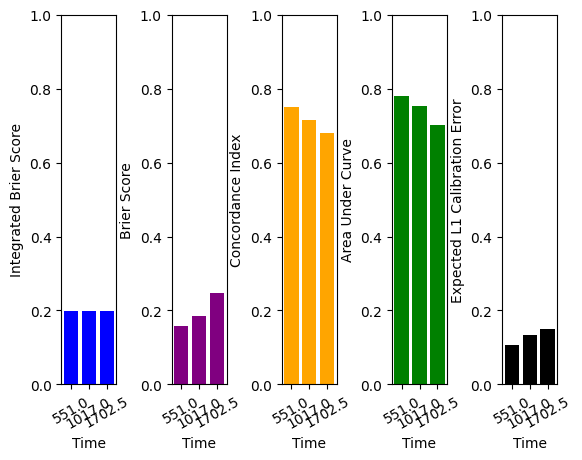

[0.779703   0.75388545 0.70077583]
[np.float64(0.750934638444082), np.float64(0.714922038800312), np.float64(0.6813575608525907)]
[0.10714074 0.13361711 0.14860219]


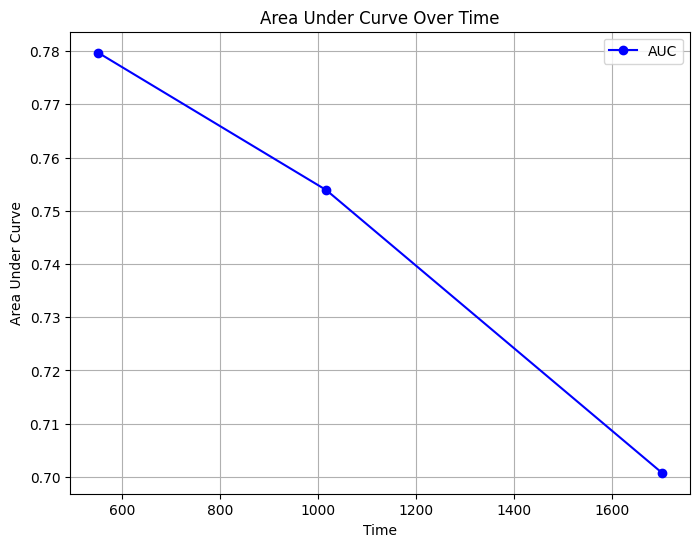

/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


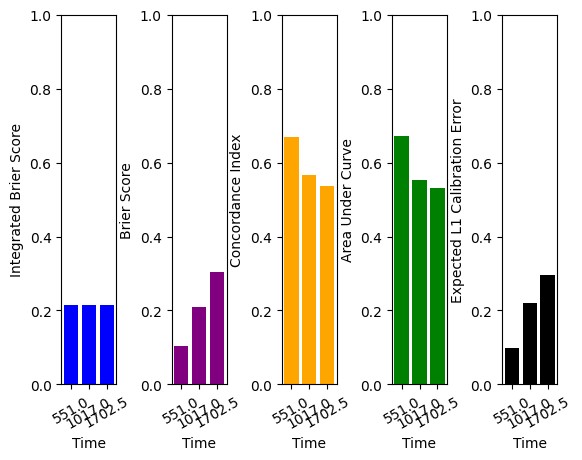

[0.67321751 0.55224902 0.53147027]
[np.float64(0.6691173358657243), np.float64(0.5659632977242653), np.float64(0.537769691506141)]
[0.09817455 0.21944751 0.29605809]


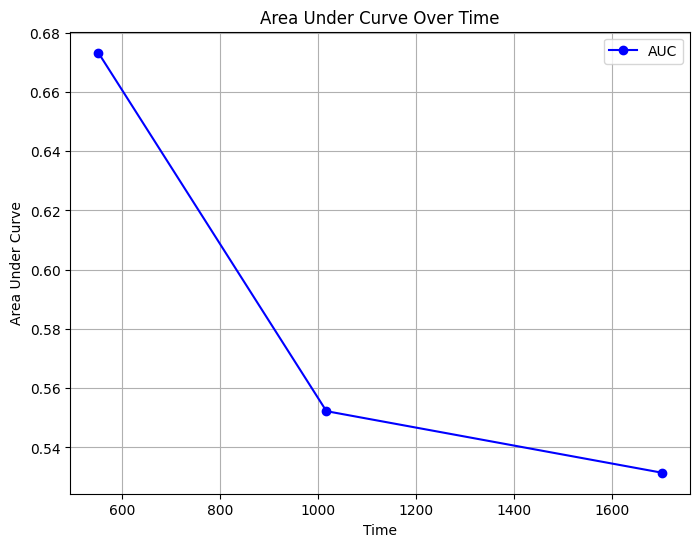

In [ ]:
#times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
rsf_predictions_te = rsf_model.predict_survival(x_te.astype(np.float64), times)
rsf_results = dict()
rsf_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr).values() ))

plot_performance_metrics(rsf_results, times)
print_performance_metrics(rsf_results['Area Under Curve'])
print_performance_metrics(rsf_results['Concordance Index'])
print_performance_metrics(rsf_results['Expected L1 Calibration Error'])
plot_auc(rsf_results['Area Under Curve'], times)

rsf_non_white_predictions_te = dcm_non_white_model.predict_survival(x_te_hormon.astype(np.float64), times_hormon)
rsf_non_white_results = dict()
rsf_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
rsf_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
rsf_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
rsf_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon)
rsf_non_white_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te_hormon, predictions=dcm_non_white_predictions_te,times=times_hormon, outcomes_train=y_tr_hormon) .values() ))

plot_performance_metrics(rsf_non_white_results, times)
print_performance_metrics(rsf_non_white_results['Area Under Curve'])
print_performance_metrics(rsf_non_white_results['Concordance Index'])
print_performance_metrics(rsf_non_white_results['Expected L1 Calibration Error'])
plot_auc(rsf_non_white_results['Area Under Curve'], times)


In [ ]:
# Create a dictionary to store all results
results_summary = {
    'Model': ['CPH', 'CPH (Non-White)', 'DCM', 'DCM (Non-White)',
              'DSM', 'DSM (Non-White)', 'RSF', 'RSF (Non-White)'],
    'AUC': [
        cph_results['Area Under Curve'],
        cph_non_white_results['Area Under Curve'],
        dcm_results['Area Under Curve'],
        dcm_non_white_results['Area Under Curve'],
        dsm_results['Area Under Curve'],
        dsm_non_white_results['Area Under Curve'],
        rsf_results['Area Under Curve'],
        rsf_non_white_results['Area Under Curve']
    ],
    'CTD': [
        cph_results['Concordance Index'],
        cph_non_white_results['Concordance Index'],
        dcm_results['Concordance Index'],
        dcm_non_white_results['Concordance Index'],
        dsm_results['Concordance Index'],
        dsm_non_white_results['Concordance Index'],
        rsf_results['Concordance Index'],
        rsf_non_white_results['Concordance Index']
    ],
    'ECE': [
        cph_results['Expected L1 Calibration Error'],
        cph_non_white_results['Expected L1 Calibration Error'],
        dcm_results['Expected L1 Calibration Error'],
        dcm_non_white_results['Expected L1 Calibration Error'],
        dsm_results['Expected L1 Calibration Error'],
        dsm_non_white_results['Expected L1 Calibration Error'],
        rsf_results['Expected L1 Calibration Error'],
        rsf_non_white_results['Expected L1 Calibration Error']
    ],
    'Brier': [
        cph_results.get('Brier Score', np.nan),
        cph_non_white_results.get('Brier Score', np.nan),
        dcm_results.get('Brier Score', np.nan),
        dcm_non_white_results.get('Brier Score', np.nan),
        dsm_results.get('Brier Score', np.nan),
        dsm_non_white_results.get('Brier Score', np.nan),
        rsf_results.get('Brier Score', np.nan),
        rsf_non_white_results.get('Brier Score', np.nan)
    ],
    'IBS': [
        cph_results.get('Integrated Brier Score', np.nan),
        cph_non_white_results.get('Integrated Brier Score', np.nan),
        dcm_results.get('Integrated Brier Score', np.nan),
        dcm_non_white_results.get('Integrated Brier Score', np.nan),
        dsm_results.get('Integrated Brier Score', np.nan),
        dsm_non_white_results.get('Integrated Brier Score', np.nan),
        rsf_results.get('Integrated Brier Score', np.nan),
        rsf_non_white_results.get('Integrated Brier Score', np.nan)
    ]
}

# Convert to DataFrame
results_df = pd.DataFrame(results_summary)

# Save to text file
with open('model_performance_results.txt', 'w') as f:
    f.write("Model Performance Results\n")
    f.write("=======================\n\n")
    f.write(results_df.to_string(index=False))

    # Add time quantiles information if available
    try:
        times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
        f.write("\n\nTime Quantiles for Evaluation:\n")
        f.write(f"25th percentile: {times[0]:.2f}\n")
        f.write(f"50th percentile (median): {times[1]:.2f}\n")
        f.write(f"75th percentile: {times[2]:.2f}\n")
    except:
        pass

print("Results saved to 'model_performance_results.txt'")

Results saved to 'model_performance_results.txt'


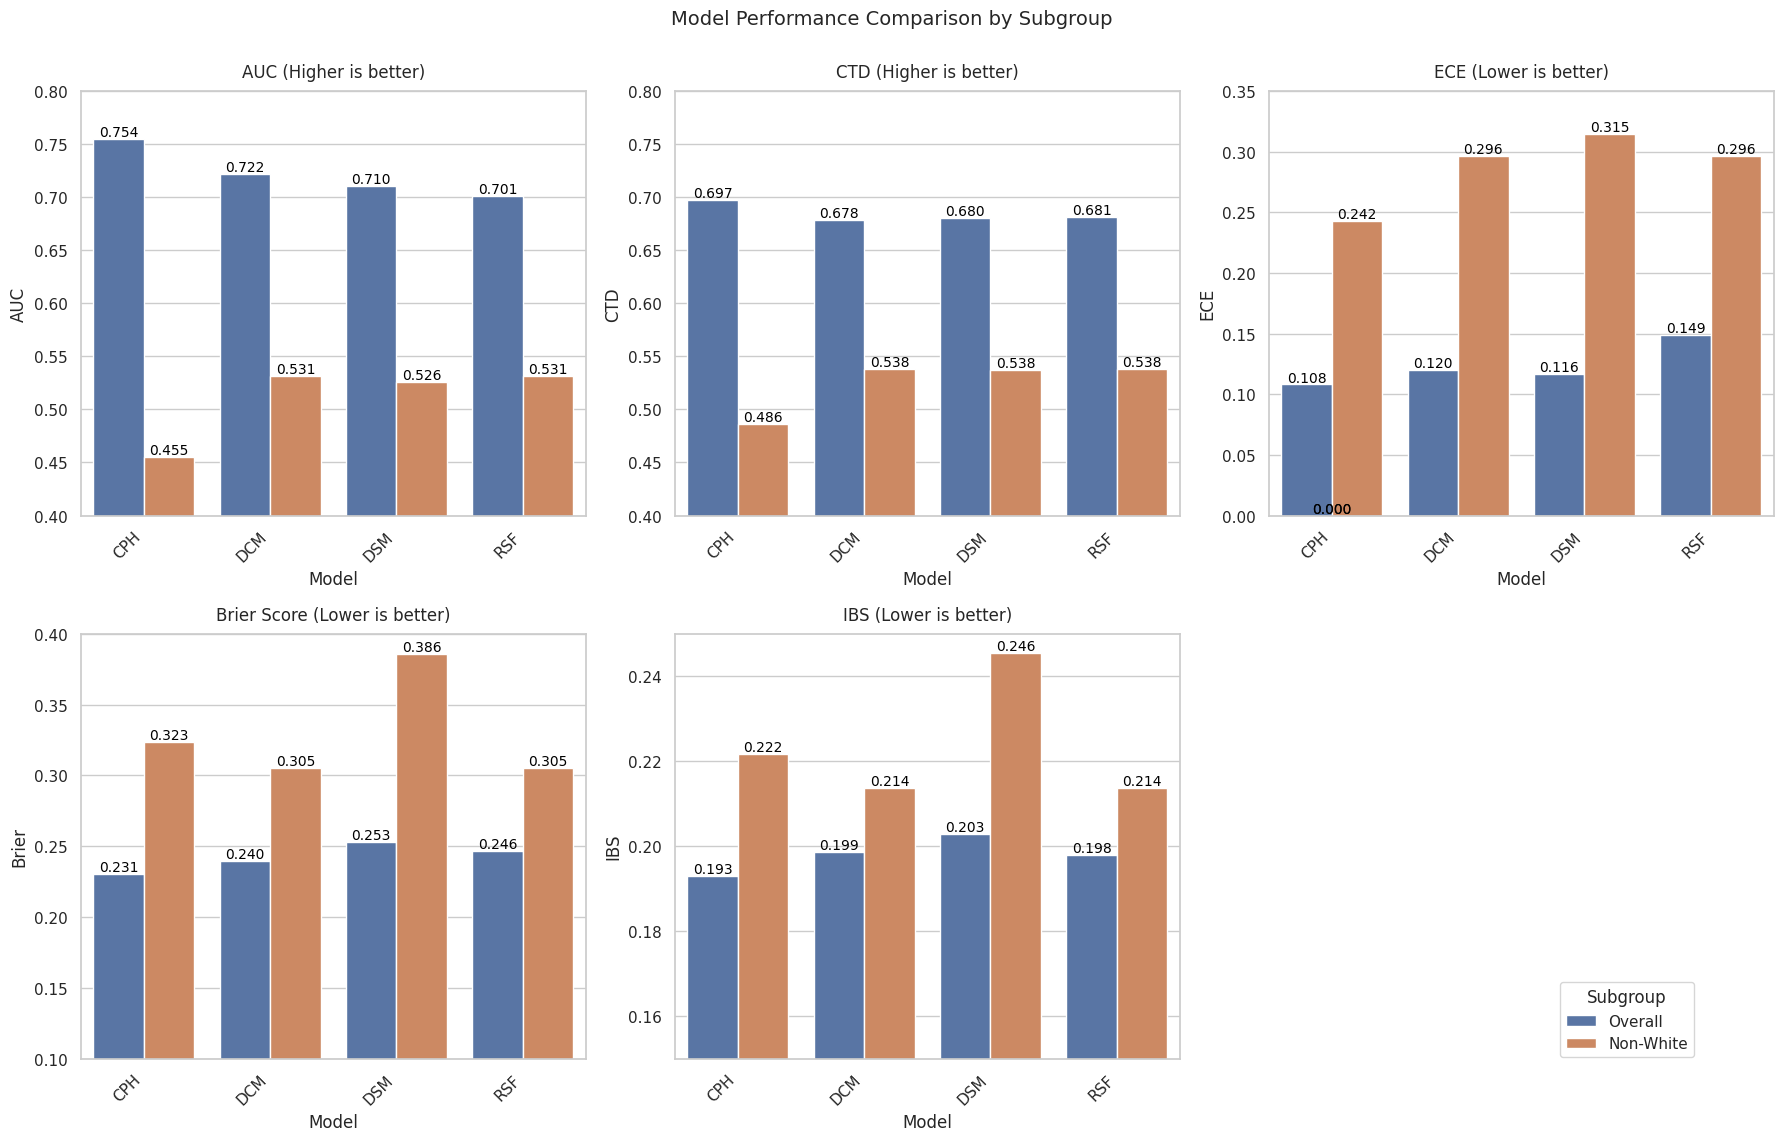

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results_summary to a DataFrame
data = {
    'Model': ['CPH', 'CPH (Non-White)', 'DCM', 'DCM (Non-White)', 'DSM', 'DSM (Non-White)', 'RSF', 'RSF (Non-White)'],
    'AUC': [x[2] for x in results_summary['AUC']],  # Use the 3rd value (index 2)
    'CTD': [x[2] for x in results_summary['CTD']],  # Use the 3rd value (index 2)
    'ECE': [x[2] for x in results_summary['ECE']],  # Use the 3rd value (index 2)
    'Brier': [x[2] for x in results_summary['Brier']],  # Use the 3rd value (index 2)
    'IBS': results_summary['IBS']  # IBS remains unchanged (single value per model)
}

df = pd.DataFrame(data)

# Create Subgroup column
df['Subgroup'] = df['Model'].apply(lambda x: 'Non-White' if '(Non-White)' in x else 'Overall')

# Clean Model names (remove " (Non-White)" suffix)
df['Model'] = df['Model'].apply(lambda x: x.split(' (')[0])

# Plotting
plt.figure(figsize=(18, 12))
sns.set_theme(style="whitegrid")

# Define a consistent color palette
palette = {'Overall': '#4C72B0', 'Non-White': '#DD8452'}

# AUC (using array[2])
plt.subplot(2, 3, 1)
ax = sns.barplot(data=df, x='Model', y='AUC', hue='Subgroup', palette=palette)
plt.title('AUC (Higher is better)', fontsize=12, pad=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.4, 0.8)
# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# CTD (using array[2])
plt.subplot(2, 3, 2)
ax = sns.barplot(data=df, x='Model', y='CTD', hue='Subgroup', palette=palette)
plt.title('CTD (Higher is better)', fontsize=12, pad=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.4, 0.8)
# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# ECE (using array[2])
plt.subplot(2, 3, 3)
ax = sns.barplot(data=df, x='Model', y='ECE', hue='Subgroup', palette=palette)
plt.title('ECE (Lower is better)', fontsize=12, pad=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 0.35)
# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Brier (using array[2])
plt.subplot(2, 3, 4)
ax = sns.barplot(data=df, x='Model', y='Brier', hue='Subgroup', palette=palette)
plt.title('Brier Score (Lower is better)', fontsize=12, pad=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.4)
# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# IBS (unchanged)
plt.subplot(2, 3, 5)
ax = sns.barplot(data=df, x='Model', y='IBS', hue='Subgroup', palette=palette)
plt.title('IBS (Lower is better)', fontsize=12, pad=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.15, 0.25)
# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add legend only once to avoid duplication
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower right', bbox_to_anchor=(0.95, 0.1), title='Subgroup')

# Remove legends from individual plots
for i in range(1, 6):
    plt.subplot(2, 3, i)
    plt.gca().get_legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Model Performance Comparison by Subgroup', fontsize=14, y=0.98)
plt.show()

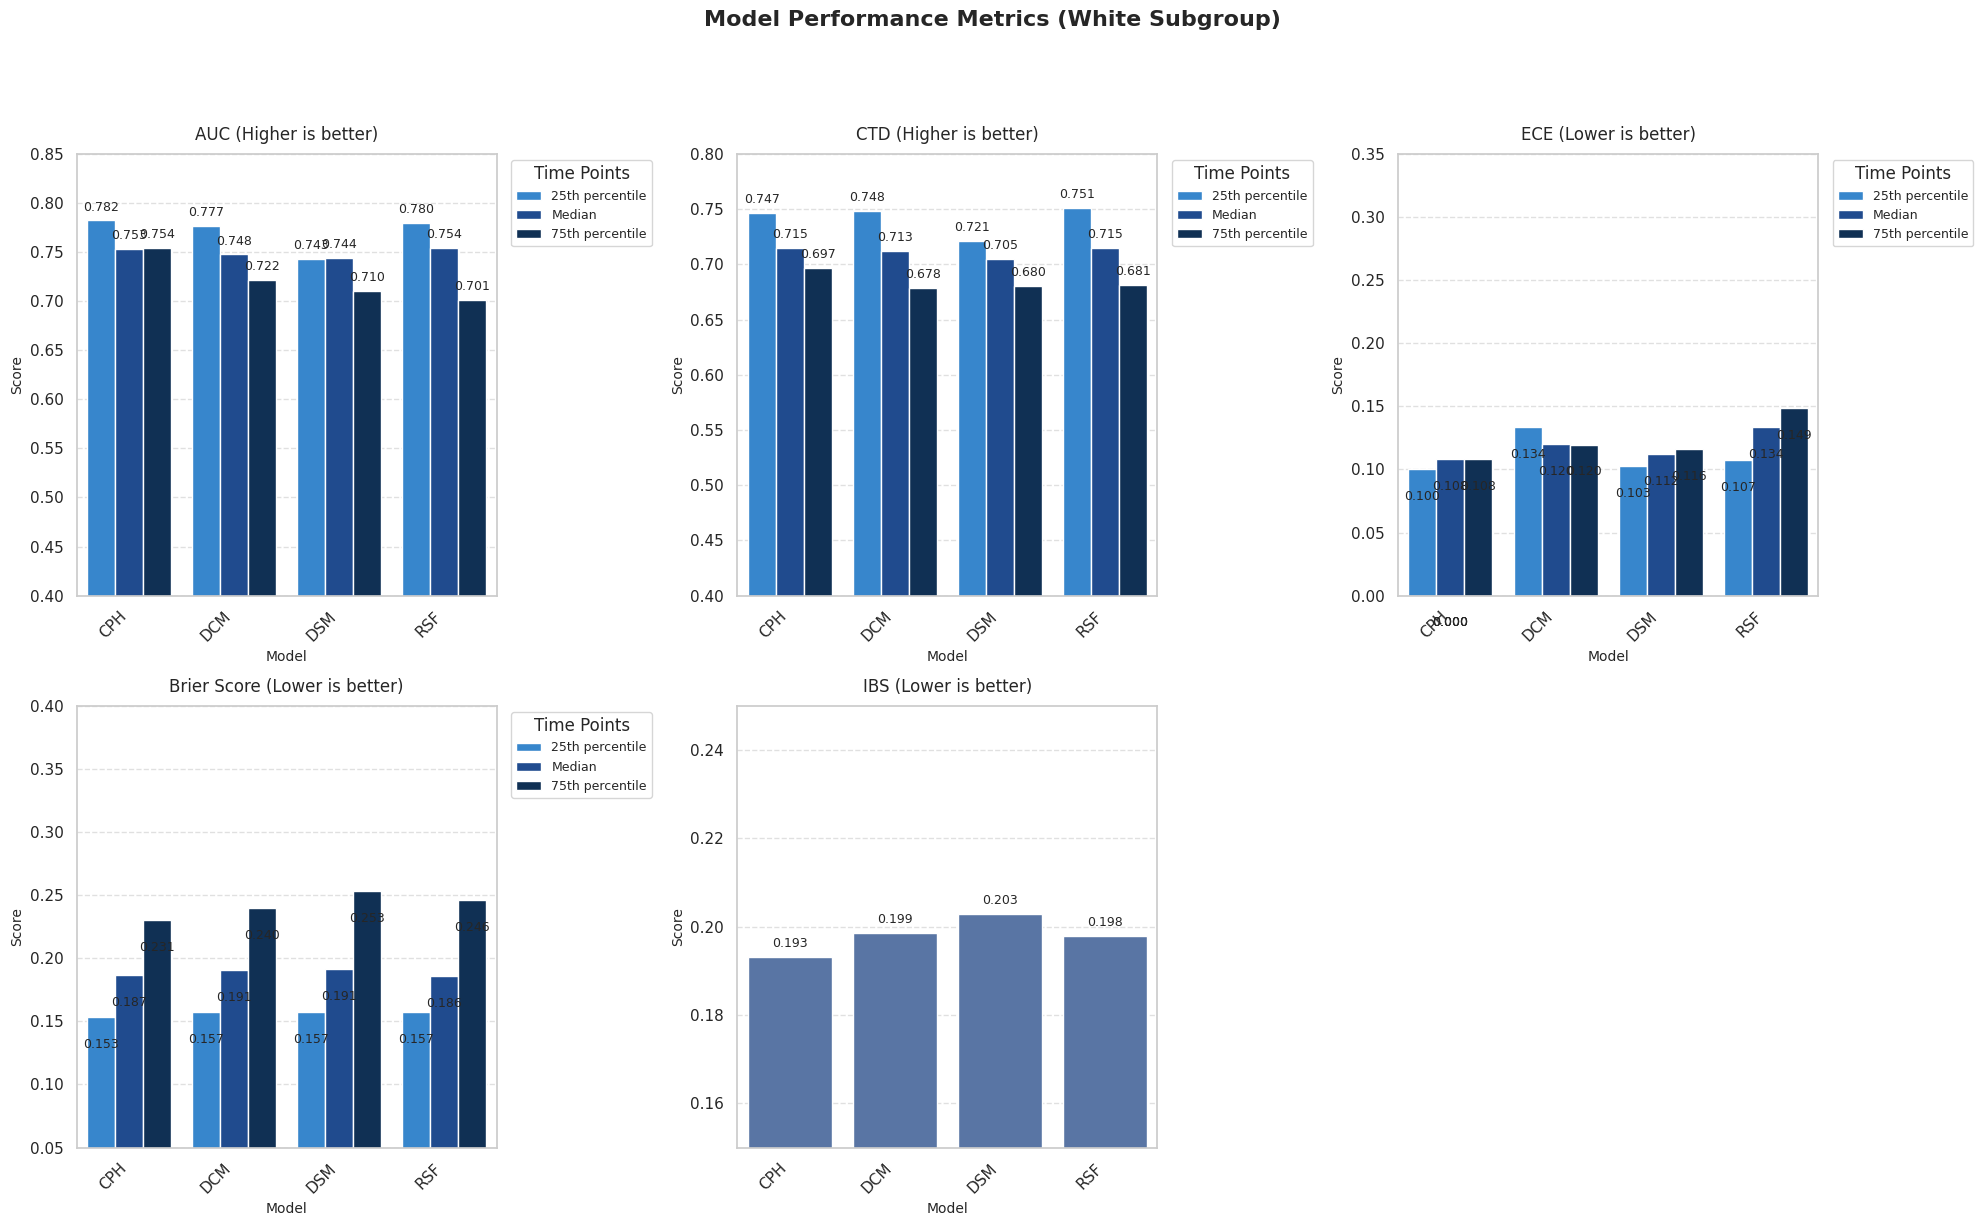

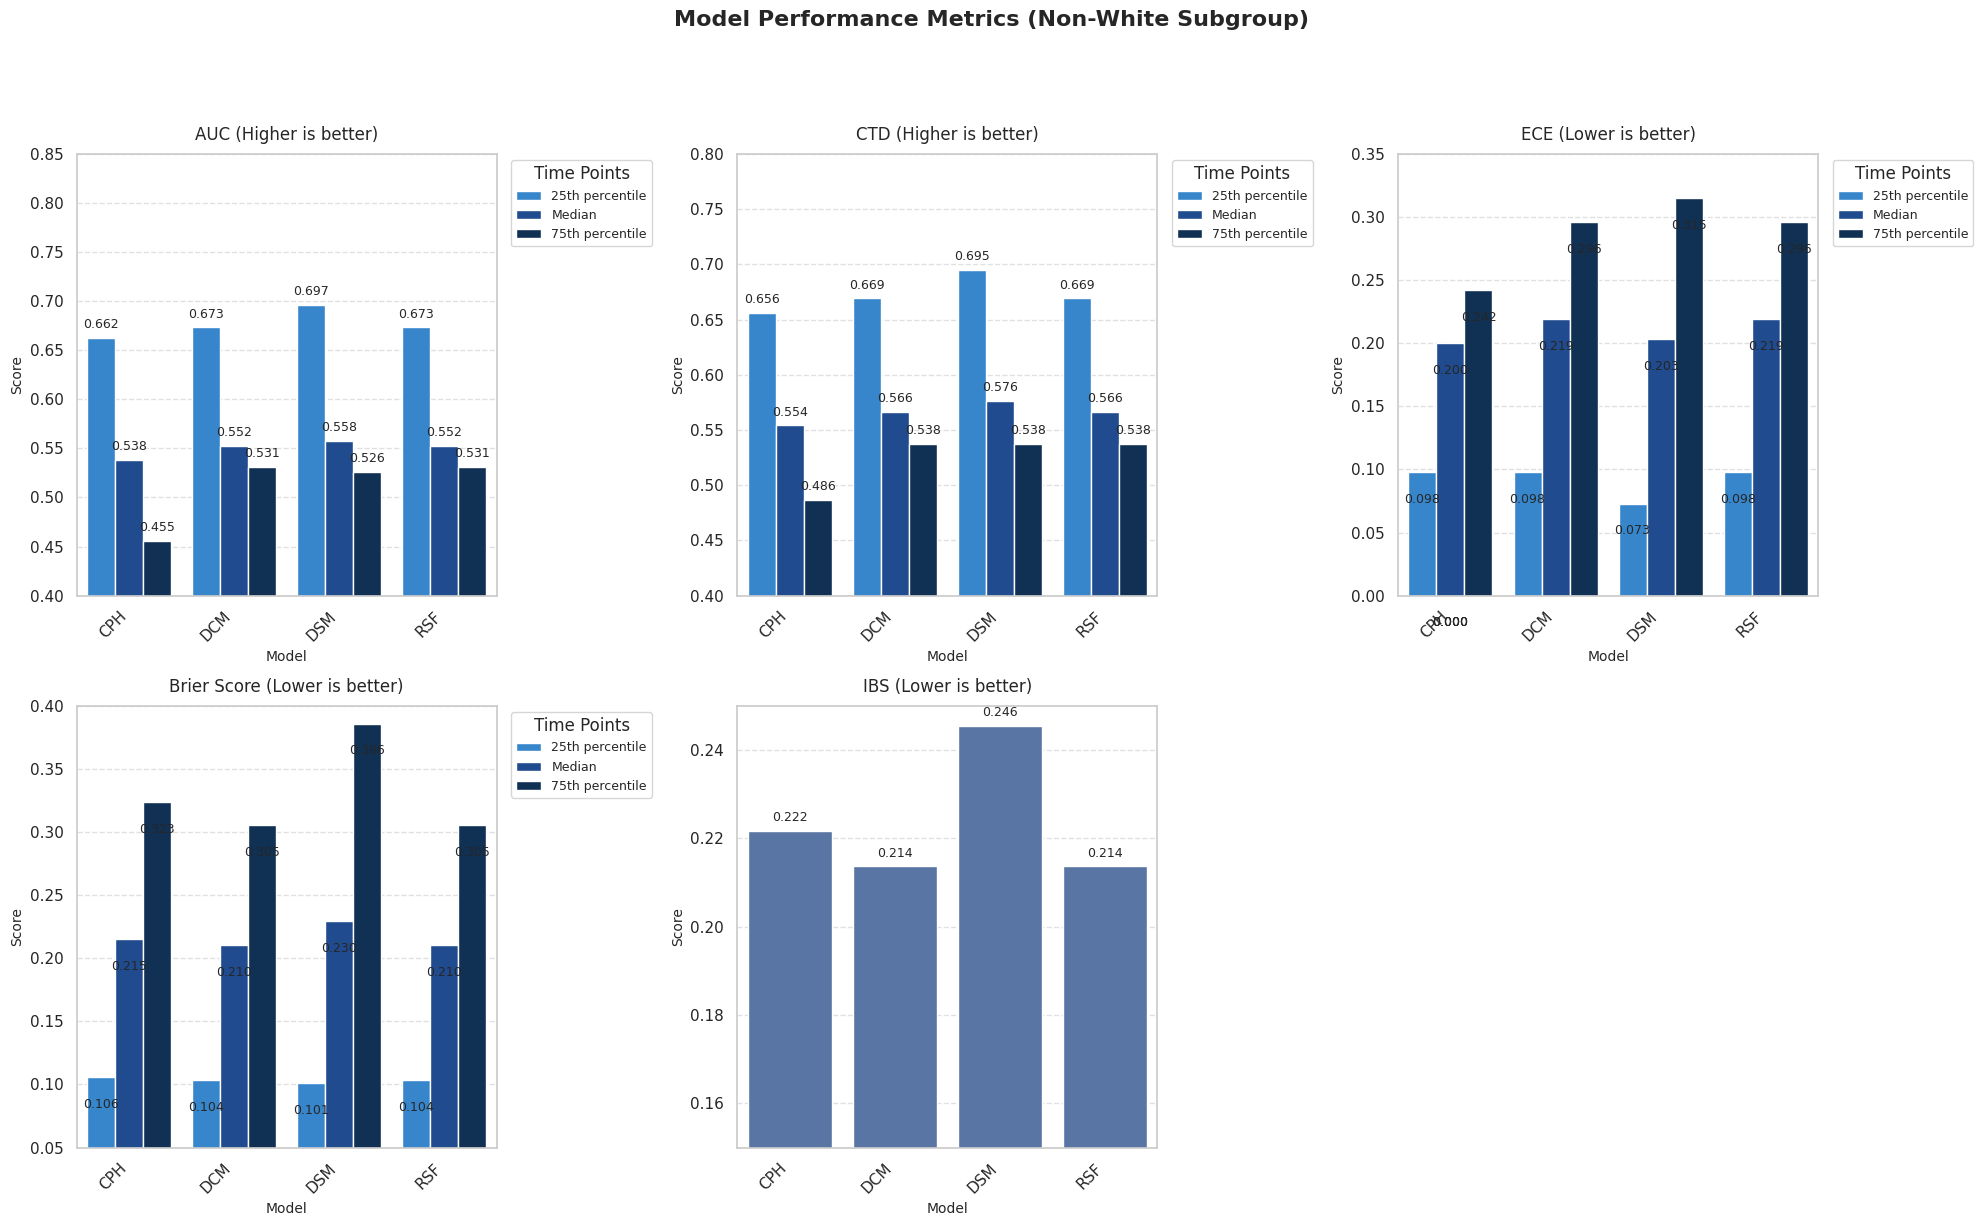

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results_summary to a DataFrame with all time points
data = {
    'Model': ['CPH', 'CPH (Non-White)', 'DCM', 'DCM (Non-White)', 'DSM', 'DSM (Non-White)', 'RSF', 'RSF (Non-White)'],
    'AUC_t0': [x[0] for x in results_summary['AUC']],
    'AUC_t1': [x[1] for x in results_summary['AUC']],
    'AUC_t2': [x[2] for x in results_summary['AUC']],
    'CTD_t0': [x[0] for x in results_summary['CTD']],
    'CTD_t1': [x[1] for x in results_summary['CTD']],
    'CTD_t2': [x[2] for x in results_summary['CTD']],
    'ECE_t0': [x[0] for x in results_summary['ECE']],
    'ECE_t1': [x[1] for x in results_summary['ECE']],
    'ECE_t2': [x[2] for x in results_summary['ECE']],
    'Brier_t0': [x[0] for x in results_summary['Brier']],
    'Brier_t1': [x[1] for x in results_summary['Brier']],
    'Brier_t2': [x[2] for x in results_summary['Brier']],
    'IBS': results_summary['IBS']  # IBS remains unchanged (single value per model)
}

df = pd.DataFrame(data)

# Create Subgroup column
df['Subgroup'] = df['Model'].apply(lambda x: 'Non-White' if '(Non-White)' in x else 'White')

# Clean Model names (remove " (Non-White)" suffix)
df['Model'] = df['Model'].apply(lambda x: x.split(' (')[0])

# Melt the DataFrame for time-point analysis
df_melted = pd.melt(
    df,
    id_vars=['Model', 'Subgroup', 'IBS'],
    value_vars=['AUC_t0', 'AUC_t1', 'AUC_t2', 'CTD_t0', 'CTD_t1', 'CTD_t2',
                'ECE_t0', 'ECE_t1', 'ECE_t2', 'Brier_t0', 'Brier_t1', 'Brier_t2'],
    var_name='Metric_Time',
    value_name='Value'
)

# Split Metric_Time into Metric and Time
df_melted[['Metric', 'Time']] = df_melted['Metric_Time'].str.split('_', expand=True)
df_melted['Time'] = df_melted['Time'].str.replace('t', '').astype(int)

# Define metrics and their properties
metrics = {
    'AUC': {'title': 'AUC (Higher is better)', 'ylim': (0.4, 0.85), 'direction': 'higher'},
    'CTD': {'title': 'CTD (Higher is better)', 'ylim': (0.4, 0.8), 'direction': 'higher'},
    'ECE': {'title': 'ECE (Lower is better)', 'ylim': (0, 0.35), 'direction': 'lower'},
    'Brier': {'title': 'Brier Score (Lower is better)', 'ylim': (0.05, 0.4), 'direction': 'lower'},
    'IBS': {'title': 'IBS (Lower is better)', 'ylim': (0.15, 0.25), 'direction': 'lower'}
}

# Custom palette and legend labels
time_palette = ["#1E88E5", "#0D47A1", "#052F5F"]  # Dark blue to very dark blue (t0 → t2)
time_labels = ['25th percentile', 'Median', '75th percentile']  # New legend labels

# Create separate plots for White and Non-White subgroups
for subgroup in ['White', 'Non-White']:
    plt.figure(figsize=(20, 12))
    sns.set_theme(style="whitegrid")
    plt.suptitle(f'Model Performance Metrics ({subgroup} Subgroup)', y=1.02, fontsize=16, weight='bold')

    # Plot each metric in a separate subplot
    for i, (metric, props) in enumerate(metrics.items(), 1):
        plt.subplot(2, 3, i)

        if metric != 'IBS':
            # Filter data for current metric and subgroup
            plot_data = df_melted[(df_melted['Metric'] == metric) &
                                 (df_melted['Subgroup'] == subgroup)]

            # Create bar plot
            ax = sns.barplot(
                data=plot_data,
                x='Model', y='Value', hue='Time',
                palette=time_palette,
                hue_order=[0, 1, 2],  # Ensure consistent ordering
                order=['CPH', 'DCM', 'DSM', 'RSF'],
                errorbar=None
            )

            # Customize plot appearance
            plt.title(props['title'], fontsize=12, pad=10)
            plt.ylim(props['ylim'])
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('Model', fontsize=10)
            plt.ylabel('Score', fontsize=10)

            # Add grid lines for better readability
            ax.yaxis.grid(True, linestyle='--', alpha=0.6)

            # Update legend with quantile labels
            handles, _ = ax.get_legend_handles_labels()
            ax.legend(handles, time_labels, title='Time Points',
                     bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

            # Add value annotations on top of bars
            for p in ax.patches:
                height = p.get_height()
                va = 'bottom' if props['direction'] == 'higher' else 'top'
                y_offset = 5 if props['direction'] == 'higher' else -15
                ax.annotate(f"{height:.3f}",
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va=va, xytext=(0, y_offset),
                           textcoords='offset points', fontsize=9)
        else:
            # IBS (single value per model)
            ax = sns.barplot(
                data=df[df['Subgroup'] == subgroup],
                x='Model', y='IBS',
                color='#4C72B0',  # Consistent with other plots
                order=['CPH', 'DCM', 'DSM', 'RSF'],
                errorbar=None
            )

            # Customize plot appearance
            plt.title(props['title'], fontsize=12, pad=10)
            plt.ylim(props['ylim'])
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('Model', fontsize=10)
            plt.ylabel('Score', fontsize=10)

            # Add grid lines
            ax.yaxis.grid(True, linestyle='--', alpha=0.6)

            # Add value annotations on top of bars
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f"{height:.3f}",
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='bottom', xytext=(0, 5),
                           textcoords='offset points', fontsize=9)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust space for suptitle
    plt.show()